In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_09c import *

# PIL transforms

In [3]:
#export
make_rgb._order = 0

In [4]:
path = untar_data(URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [5]:
def get_il(tfms): return ImageList.from_files(path, tfms=tfms)

In [6]:
il = get_il(tfms)

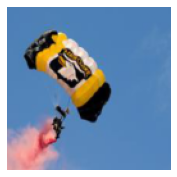

In [7]:
show_image(il[0])

In [8]:
img = PIL.Image.open(il.items[0])

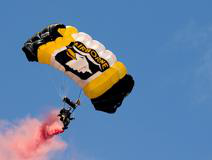

In [9]:
img 

In [10]:
img.getpixel((1,1))

(76, 127, 182)

In [11]:
import numpy as np

In [12]:
%timeit -n 10 a = np.array(PIL.Image.open(il.items[0]))

602 µs ± 66.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


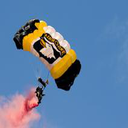

In [13]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

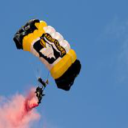

In [14]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

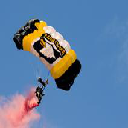

In [15]:
img.resize((128,128), resample=PIL.Image.NEAREST)

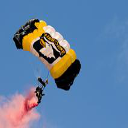

In [16]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

In [17]:
%timeit img.resize((224,224), resample=PIL.Image.BICUBIC)

725 µs ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%timeit img.resize((224,224), resample=PIL.Image.BILINEAR)

470 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%timeit img.resize((224,224), resample=PIL.Image.NEAREST)

36.3 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Flip

In [20]:
#export
import random

In [21]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < 0.5 else x

In [22]:
il1 = get_il(tfms)
il1.items[0]

Path('/home/sandmann/.fastai/data/imagenette2-160/val/n03888257/n03888257_24470.JPEG')

In [23]:
il1.items = [il1.items[0]] * 64

In [24]:
dl = DataLoader(il1, 8)

In [25]:
x = next(iter(dl))

In [26]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1,1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))
    
def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig, axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x, axes.flat): show_image(xi, ax)

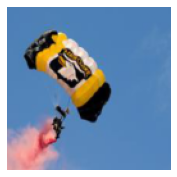

In [27]:
show_image(x[0])

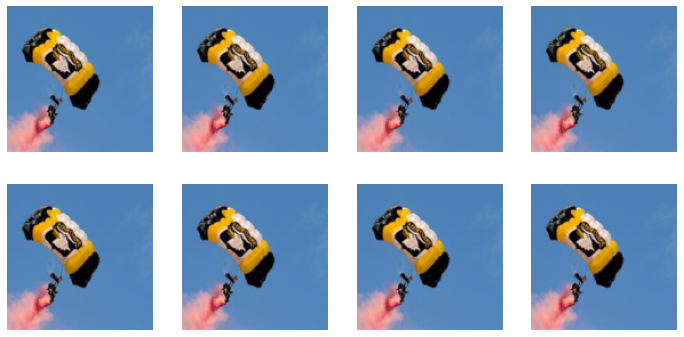

In [28]:
show_batch(x)

In [29]:
il1.tfms.append(pil_random_flip)

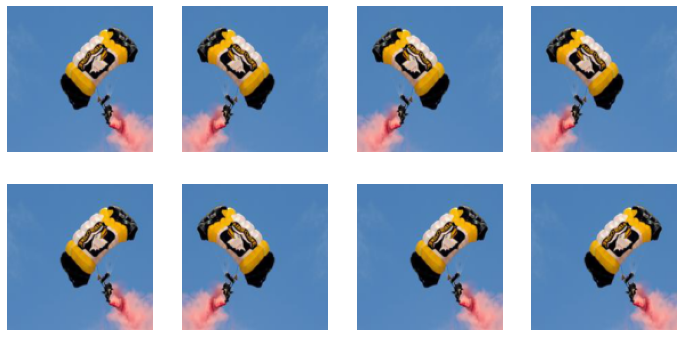

In [30]:
x = next(iter(dl))
show_batch(x)

In [31]:
class PilRandomFlip(Transform):
    _order = 11
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else x

In [32]:
#export
class PilTransform(Transform): _order = 11
    
class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x): return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else x

In [33]:
del(il1.tfms[-1])

In [34]:
il1.tfms

[<function exp.nb_08.make_rgb(item)>,
 <function exp.nb_08.to_byte_tensor(item)>,
 <function exp.nb_08.to_float_tensor(item)>]

In [35]:
il1.tfms.append(PilRandomFlip(0.8))

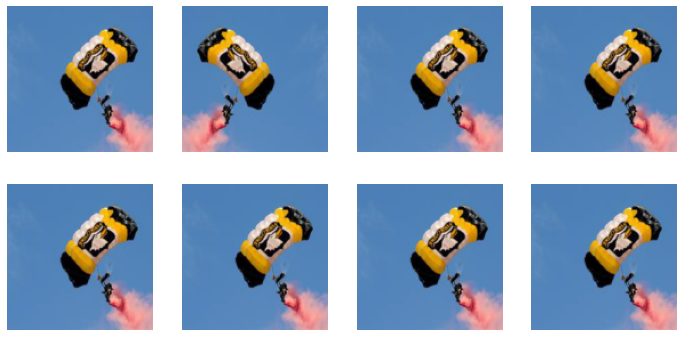

In [36]:
x = next(iter(dl))
show_batch(x)

In [37]:
PIL.Image.FLIP_LEFT_RIGHT, PIL.Image.ROTATE_270, PIL.Image.TRANSVERSE

(0, 4, 6)

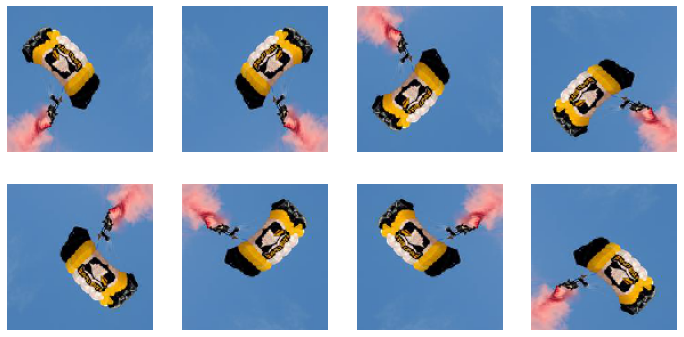

In [38]:
img = PIL.Image.open(il.items[0])
img = img.resize((128,128), resample=PIL.Image.NEAREST)
_, axs = plt.subplots(2,4, figsize=(12,6))
for i, ax in enumerate(axs.flatten()):
    if i == 0: ax.imshow(img)
    else: ax.imshow(img.transpose(i-1))
    ax.axis('off')

In [39]:
#export
class PILRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p = p * 7/8
    def __call__(self, x):
        if random.random() > self.p: return x
        return x.transpose(random.randint(0,6))

In [40]:
del(il1.tfms[-1])
il1.tfms.append(PILRandomDihedral())

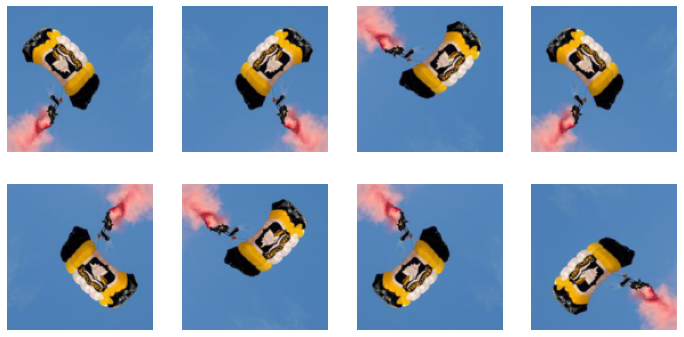

In [41]:
show_batch(next(iter(dl)))

# RandomCrop

In [42]:
img = PIL.Image.open(il.items[0])
img.size

(212, 160)

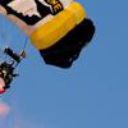

In [43]:
img.crop((60,60,160,160)).resize((128,128), resample=PIL.Image.BILINEAR)

In [44]:
cnr2 = (60,60,160,160)
resample = PIL.Image.BILINEAR

In [45]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

272 µs ± 52.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


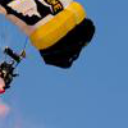

In [46]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [47]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

965 µs ± 424 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
#export
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0], sz[0]])

In [49]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:75% !important; }</style>"))
process_sz((128,128)), process_sz(128)

((128, 128), (128, 128))

In [50]:
#export
def default_crop_size(w,h): return [w,w] if w < h else [h,h]

In [51]:
#export
class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR):
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)
    def get_corners(self, w, h, wc, hc): return (0,0,w,h) # full image
    
    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    

In [52]:
#export
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w, h): return [w/self.scale, h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [53]:
il1.tfms = [make_rgb, GeneralCrop(128), to_byte_tensor, to_float_tensor]

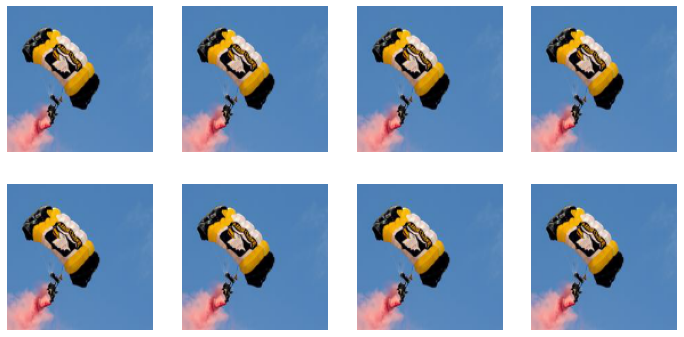

In [54]:
show_batch(next(iter(dl)))

In [55]:
#export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
        
    def get_corners(self, w, h, wc, hc):
        area = w * h
        # Tries 10 times to get a proper crop inside the image
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w-new_w)
                top = random.randint(0, h-new_h)
                return (left, top, left + new_w, top + new_h)
            
        # Fallback to squish
        if w/h < self.ratio[0]: size = (w, int(w/self.ratio[0]))
        elif w/h > self.ratio[1]: size = (int(h*self.ratio[1]), h)
        else: size = (w,h)
        return ((w-size[0])//2, (h-size[1])//2, (w+size[0])//2, (h+size[1])//2)

In [56]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

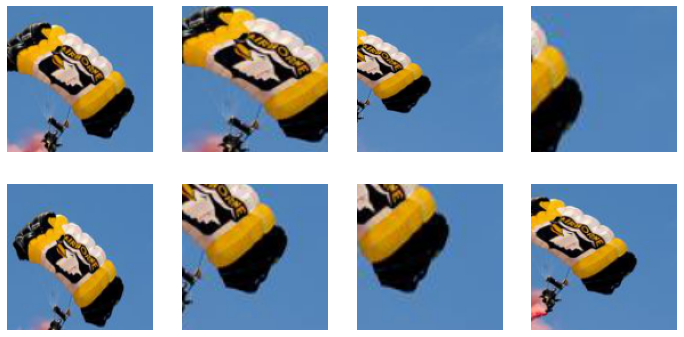

In [57]:
show_batch(next(iter(dl)))

# Perspective warping

In [58]:
#export
from torch import FloatTensor, LongTensor

In [59]:
#export
def find_coeffs(orig_pts, targ_pts):
    matrix = []
    # The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
        
    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8,1)
    # The 8 scalars we seek are solution of AX = B
#     return list(torch.solve(B,A)[0][:,0])
    return list(torch.linalg.solve(A,B)[:,0])

In [60]:
#export
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0), (0,h), (w,h), (w,0))
    c = find_coeffs(src_coords, targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [61]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

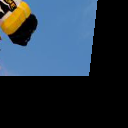

In [62]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

In [63]:
%timeit -n 10 warp(img, (128,128), src)

657 µs ± 85.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
%timeit -n 10 warp(img, (128,128), src, resample=PIL.Image.NEAREST)

239 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


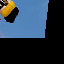

In [65]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

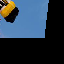

In [66]:
warp(img, (64,64), src, resample=PIL.Image.NEAREST)

In [67]:
#export
def uniform(a,b): return a + (b-a) * random.random()

In [68]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST):
        self.size,self.magnitude,self.resample = process_sz(size),magnitude,resample
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        up_t, lr_t = uniform(-self.magnitude, self.magnitude), uniform(-self.magnitude, self.magnitude)
        left, top = randint(0, x.size[0] - csize[0]), randint(0, x.size[1] - csize[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left, top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [69]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.1), to_byte_tensor, to_float_tensor]

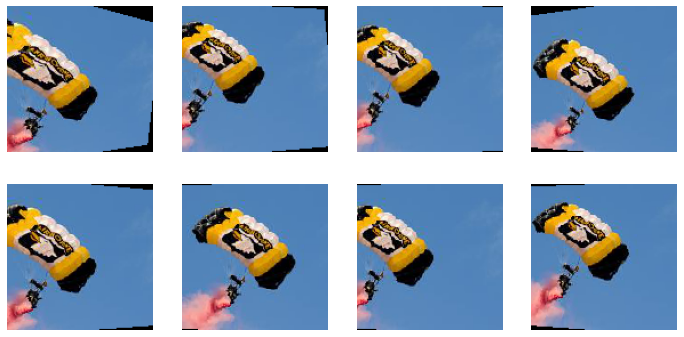

In [70]:
x = next(iter(dl))
show_batch(x)

In [71]:
# export
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn  = min(self.magnitude, top /csize[1], (x.size[1]-top) /csize[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [72]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.1), to_byte_tensor, to_float_tensor]

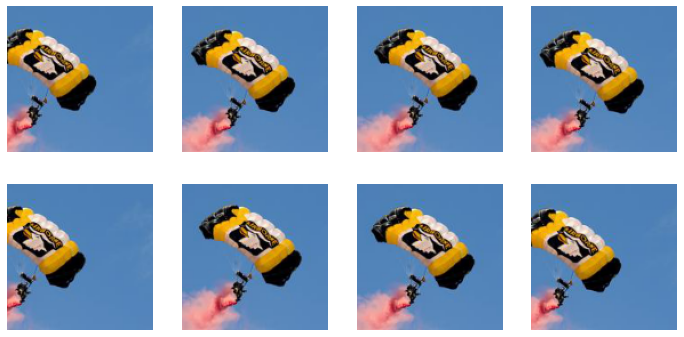

In [73]:
x = next(iter(dl))
show_batch(x)

# Faster tensor creation 

In [74]:
[(o._order, o) for o in sorted(tfms, key=lambda x: x._order)]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7f079c0b2ca0>),
 (11, <__main__.PILRandomDihedral at 0x7f07128c2130>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

In [75]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [76]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

136 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
%timeit -n 10 np_to_float(img)

199 µs ± 29.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Batch data augmentation

## Step 1: generate the grid

In [78]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.2), to_byte_tensor, to_float_tensor]

In [79]:
dl = DataLoader(il1, 64)

In [80]:
x = next(iter(dl))

In [81]:
from torch import FloatTensor

In [82]:
def affine_grid_cpu(size):
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:,:,:,0] = torch.outer(torch.ones(H), linear_points).expand_as(grid[:,:,:,0])
    linear_points = torch.linspace(-1,1,H) if H > 1 else tensor([-1])
    grid[:,:,:,1] = torch.outer(linear_points, torch.ones(W)).expand_as(grid[:,:,:,1])
    return grid

In [83]:
grid = affine_grid_cpu(x.size())

In [84]:
grid.shape

torch.Size([64, 128, 128, 2])

In [85]:
grid[0,:5,:5]

tensor([[[-1.0000, -1.0000],
         [-0.9843, -1.0000],
         [-0.9685, -1.0000],
         [-0.9528, -1.0000],
         [-0.9370, -1.0000]],

        [[-1.0000, -0.9843],
         [-0.9843, -0.9843],
         [-0.9685, -0.9843],
         [-0.9528, -0.9843],
         [-0.9370, -0.9843]],

        [[-1.0000, -0.9685],
         [-0.9843, -0.9685],
         [-0.9685, -0.9685],
         [-0.9528, -0.9685],
         [-0.9370, -0.9685]],

        [[-1.0000, -0.9528],
         [-0.9843, -0.9528],
         [-0.9685, -0.9528],
         [-0.9528, -0.9528],
         [-0.9370, -0.9528]],

        [[-1.0000, -0.9370],
         [-0.9843, -0.9370],
         [-0.9685, -0.9370],
         [-0.9528, -0.9370],
         [-0.9370, -0.9370]]])

In [86]:
%timeit -n 10 grid = affine_grid_cpu(x.size())

2.4 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [87]:
m = tensor([[1., 0., 0.], [0., 1., 0.]])
theta = m.expand(x.size(0), 2, 3)

In [88]:
theta.shape

torch.Size([64, 2, 3])

In [89]:
%timeit -n 10 grid = F.affine_grid(theta, x.size())

7.51 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [90]:
%timeit -n 10 grid = F.affine_grid(theta.cuda(), x.size())

The slowest run took 13.34 times longer than the fastest. This could mean that an intermediate result is being cached.
4.25 ms ± 6.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
def affine_grid(x, size):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0), x.size(1)) + size
    if x.device.type == 'cpu': return affine_grid_cpu(size)
    m = tensor([[1.,0.,0.], [0.,1.,0.]], device=x.device)
    return F.affine_grid(m.expand(x.size(0), 2, 3), size)

In [92]:
grid = affine_grid(x, 128)

## Step 2: AFfine multiplication

In [93]:
from torch import stack,zeros_like,ones_like

In [94]:
def rotation_matrix(thetas):
    thetas.mul_(math.pi/180)
    rows = [stack([thetas.cos(),             thetas.sin(),             torch.zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),            thetas.cos(),             torch.zeros_like(thetas)], dim=1),
            stack([torch.zeros_like(thetas), torch.zeros_like(thetas), torch.ones_like(thetas)], dim=1)]
    return stack(rows, dim=1)

In [95]:
thetas = torch.empty(x.size(0)).uniform_(-30,30)

In [96]:
thetas[:5]

tensor([-26.8641, -15.9387,   3.4316,  21.6128, -26.7920])

In [97]:
m = rotation_matrix(thetas)

In [98]:
m.shape, m[:,None].shape, grid.shape

(torch.Size([64, 3, 3]),
 torch.Size([64, 1, 3, 3]),
 torch.Size([64, 128, 128, 2]))

In [99]:
grid.view(64, -1, 2).shape

torch.Size([64, 16384, 2])

In [100]:
a = m[:,:2,:2]
b = m[:,2:,:2]
a.shape, b.shape

(torch.Size([64, 2, 2]), torch.Size([64, 1, 2]))

In [101]:
tfm_grid = (grid.view(64,-1,2) @ a + b).view(64, 128, 128, 2)

In [102]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]

9.54 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

6.91 ms ± 542 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:, :2, :2].unsqueeze(1)) + m[:, 2, :2][:, None, None]

9.01 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:, :2, :2]) + m[:, 2, :2][:, None]).view(-1, 128, 128, 2)

7.4 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


And on the GPU

In [106]:
grid = grid.cuda()
m = m.cuda()

In [107]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]

The slowest run took 4.21 times longer than the fastest. This could mean that an intermediate result is being cached.
99.4 µs ± 66.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [108]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

101 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:, :2, :2].unsqueeze(1)) + m[:, 2, :2][:, None, None]

81.9 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [110]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:, :2, :2]) + m[:, 2, :2][:, None]).view(-1, 128, 128, 2)

The slowest run took 4.90 times longer than the fastest. This could mean that an intermediate result is being cached.
81.5 µs ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Step 3: Interpolate

In [111]:
tfm_grid = torch.bmm(grid.view(64,-1,2), m[:,:2,:2]).view(-1, 128, 128, 2)

In [112]:
tfm_x = F.grid_sample(x, tfm_grid.cpu())

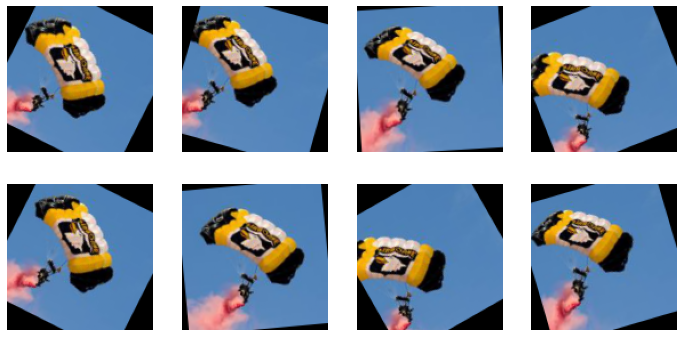

In [113]:
show_batch(tfm_x, r=2)

In [114]:
tfm_x = F.grid_sample(x, tfm_grid.cpu(), padding_mode='reflection')

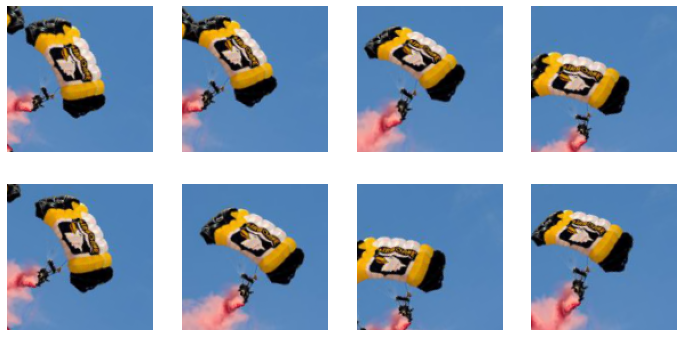

In [115]:
show_batch(tfm_x, r=2)

## Timing

In [116]:
def rotate_batch(x, size, degrees):
    grid = affine_grid(x, size)
    thetas = x.new(x.size(0)).uniform_(-degrees, degrees)
    m = rotation_matrix(thetas)
    tfm_grid = grid @ m[:, :2, :2].unsqueeze(1) + m[:, 2, :2][:, None, None]
    return F.grid_sample(x, tfm_grid)

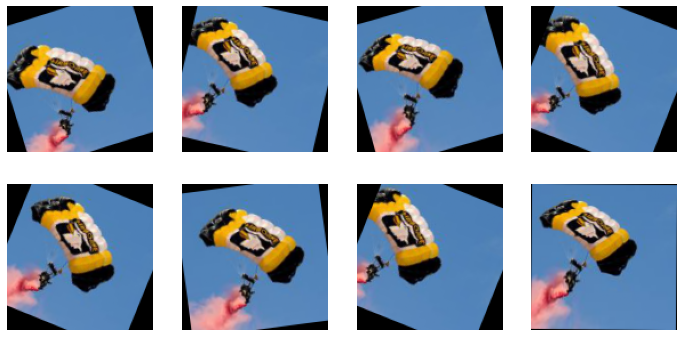

In [117]:
show_batch(rotate_batch(x, 128, 30), r=2)

In [118]:
%timeit -n 10 tfm_x = rotate_batch(x, 128, 30)

22.9 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [119]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

14.5 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## But we can be even faster

In [120]:
from torch import Tensor

In [121]:
from torch.jit import script

@script
def rotate_batch(x:Tensor, size:int, degrees:float) -> Tensor:
    sz = (x.size(0),x.size(1)) + (size,size)
    idm = torch.zeros(2,3, device=x.device)
    idm[0,0] = 1.
    idm[1,1] = 1.
    grid = F.affine_grid(idm.expand(x.size(0), 2, 3), sz)
    thetas = torch.zeros(x.size(0), device=x.device).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2].unsqueeze(1).unsqueeze(2)
    return F.grid_sample(x, tfm_grid)

In [122]:
m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)

In [123]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

17.7 ms ± 8.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### affine multiplication with affine_grid

In [124]:
def rotate_batch(x, size, degrees):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0), x.size(1)) + size
    thetas = x.new(x.size(0)).uniform_(-degrees, degrees)
    m = rotation_matrix(thetas)
    grid = F.affine_grid(m[:, :2], size)
    return F.grid_sample(x.cuda(), grid)

In [125]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

11.8 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [126]:
!python notebook2script.py 10_augmentation.ipynb

Converted 10_augmentation.ipynb to exp/nb_10.py
